The work in this notebook is based on:
- https://github.com/pierremtb/PINNs-TF2.0
- https://github.com/janblechschmidt/PDEsByNNs

# Approximating the solution of an Ecological Diffusion Equation.

In this notebook we find an approximated solution of the following PDE system so we can sample some data. We consider the two-dimensional EDE equation on the spatial domain $\mathcal{D} = [0, 1] \times [0, 1]$ and temporal domain $\mathcal{T} = [0,3]$.

$$
\begin{aligned}
    \frac{\partial}{\partial t} u (t,x,y) - \nabla^2 [\mu(x,y,t) u(t,x,y)] - \lambda(x,y,t) u(t,x,y) (1 - u(t,x,y)) &= 0, \quad &&\quad (t,x,y) \in (0,3] \times (0, 1) \times (0, 1),\\
   u(0, x, y) &= f_0(x,y),                 \quad &&\quad x, y \in [0,1] \times [0, 1],\\
   u(t, 0, y) = u(t,1, y) = u(t, x, 0) = u(t, x, 1) &= 0,              \quad &&\quad t \in (0,3] \text{ and } x, y \in [0,1] \times [0, 1].
\end{aligned}
$$
where the initial condition is specified by
$$
f_0(x,y) = \{ 1+ \exp(-3) \}^{-1} \exp \bigg[ - \frac{ (x-0.5)^2+ (y-0.5)^2  }{ (2\times 0.1^2) } \bigg].
$$
The log-diffusion and log-growth coefficients are
$$
\begin{aligned}
\log [\mu(x,y,t)] &= -10 - 1 \times h_1(x,y) \\
\log [\lambda(x,y,t)] &= 0.1 - 0.01 \times h_1(x,y),
\end{aligned}
$$
respectively, with $h_1$ a covariate assumed to follow
$$
h_1(x,y) = \{ 1+ \exp(-2) \}^{-1} \exp \bigg[ - \frac{ (x-0.2)^2+ (y-0.2)^2  }{ (2\times 0.4^2) } \bigg]
$$


In [ ]:
# Import section
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import pandas as pd
import random
from time import time

# Set data type to float32
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

In [ ]:
# Parameters for log-mu and log-lambda
alpha0 = -10.0
alpha1 = -1.0

gamma0 = 0.1
gamma1 = 0.01

# Location of initial population
s1_0 = 0.5
s2_0 = 0.5

# Parameters for initial condition
kappa0 = 3.0
sigma = 0.10


# Define function for initial condition
def fun_u_0(x, y):
    initial_prev = 1.0 / (1.0 + tf.exp(-kappa0))
    initial_variance = 1.0 / (2.0 * tf.math.pow(sigma, 2.0))
    sol = tf.exp(
        -(tf.math.square(tf.subtract(x, s1_0)) + tf.math.square(tf.subtract(y, s2_0)))
    )
    sol = initial_prev * tf.math.pow(sol, initial_variance)
    return tf.cast(sol, dtype=DTYPE)


# Define function for boundary condition
def fun_u_b(t, x, y):
    n = x.shape[0]
    return tf.zeros((n, 1), dtype=DTYPE)


# This is a function to simulate a covariate that can be observed in any point in space.
# It is based on a Gaussian kernel.
def covariate_function(x, y):
    intensity = 1.0 / (1.0 + tf.exp(2.0))
    variation = 1.0 / (2.0 * tf.math.pow(0.4, 2.0))
    covar = tf.exp(
        -(tf.math.square(tf.subtract(x, 0.2)) + tf.math.square(tf.subtract(y, 0.2)))
    )
    return intensity * tf.math.pow(covar, variation)


# Set the number of initial, boundary and colocation points
N_0 = 1000
N_b = 1000
N_r = 10000

# Set temporal and spatial boundary
tmin = 0.0
tmax = 3.0

xmin = 0.0
xmax = 1.0

ymin = 0.0
ymax = 1.0

# Set lower bounds
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Set upper bounds
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set a random seed
tf.random.set_seed(24)

# Draw uniform sample points for initial condition data
t_0 = tf.ones((N_0, 1), dtype=DTYPE) * lb[0]
x_0 = tf.concat(
    [
        tf.random.uniform((N_0 - 1, 1), lb[1], ub[1], dtype=DTYPE),
        0.5 * tf.ones((1, 1), dtype=DTYPE),
    ],
    0,
)
y_0 = tf.concat(
    [
        tf.random.uniform((N_0 - 1, 1), lb[2], ub[2], dtype=DTYPE),
        0.5 * tf.ones((1, 1), dtype=DTYPE),
    ],
    0,
)
X_0 = tf.concat([t_0, x_0, y_0], axis=1)

# Then evaluate intitial condition
u_0 = fun_u_0(x_0, y_0)

# Draw uniform sample points for boundary condition data
t_b = tf.random.uniform((N_b, 1), lb[0], ub[0], dtype=DTYPE)
x1_b = tf.keras.backend.random_uniform(
    (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
)
x2_b = tf.keras.backend.random_uniform(
    (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
)
x_b = tf.concat(
    [
        x1_b,
        lb[1] * tf.ones((N_b // 4, 1), dtype=DTYPE),
        x2_b,
        ub[1] * tf.ones((N_b // 4, 1), dtype=DTYPE),
    ],
    0,
)

y1_b = tf.keras.backend.random_uniform(
    (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
)
y2_b = tf.keras.backend.random_uniform(
    (N_b // 4, 1), minval=0.0, maxval=1.0, dtype=DTYPE
)
y_b = tf.concat(
    [
        lb[2] * tf.ones((N_b // 4, 1), dtype=DTYPE),
        y1_b,
        ub[2] * tf.ones((N_b // 4, 1), dtype=DTYPE),
        y2_b,
    ],
    0,
)
X_b = tf.concat([t_b, x_b, y_b], axis=1)

# Then evaluate boundary condition
u_b = fun_u_b(t_b, x_b, y_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r, 1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r, 1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r, 1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)

# Collect boundary and inital data in a lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

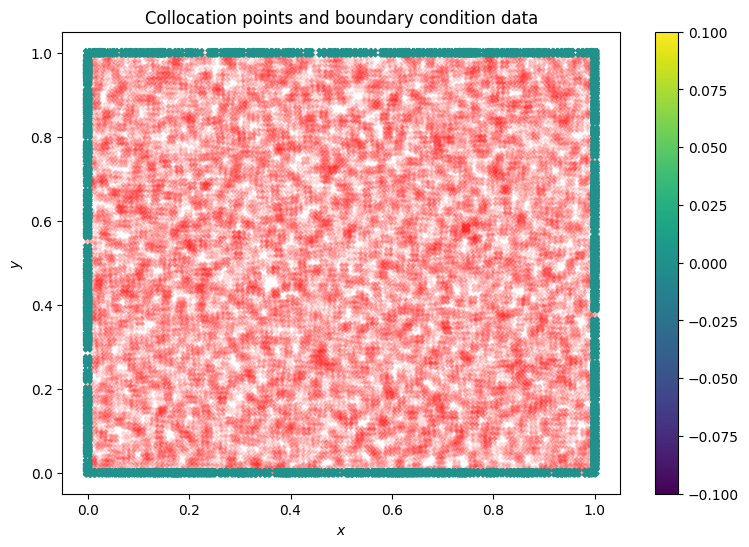

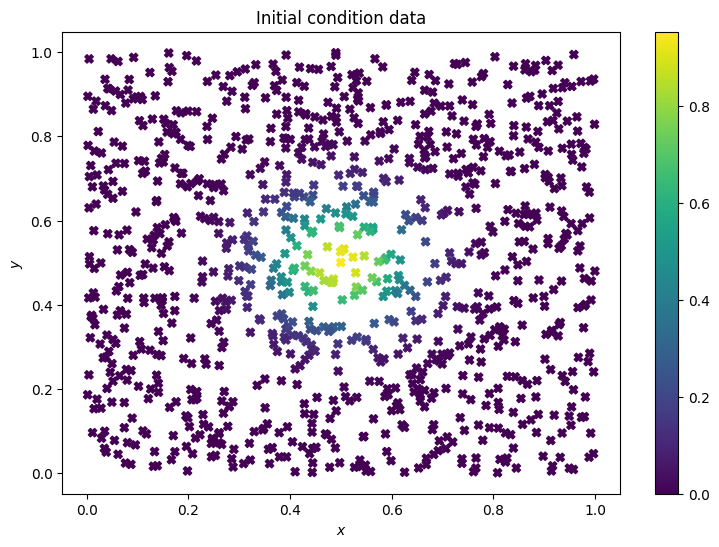

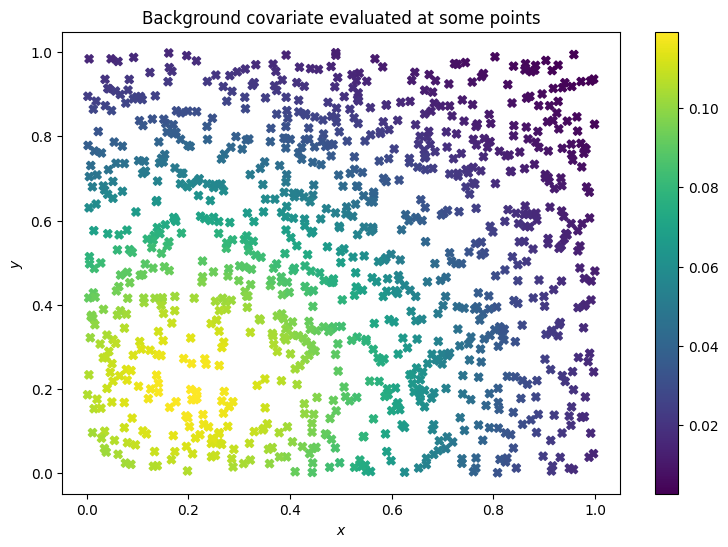

In [ ]:
# Visualize the boundary condition and the colocation points
fig = plt.figure(figsize=(9, 6))
plt.scatter(x_r, y_r, c="r", marker="X", alpha=0.1)
img = plt.scatter(x_b, y_b, c=u_b, marker="X", vmin=np.min(u_b), vmax=np.max(u_b))
fig.colorbar(img)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Collocation points and boundary condition data")

# Visualize the initial condition
fig = plt.figure(figsize=(9, 6))
img = plt.scatter(x_0, y_0, c=u_0, marker="X", vmin=np.min(u_0), vmax=np.max(u_0))
fig.colorbar(img)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Initial condition data")

# Visualize the spatial covariate
covar_0 = covariate_function(x_0, y_0)
fig = plt.figure(figsize=(9, 6))
img = plt.scatter(
    x_0, y_0, c=covar_0, marker="X", vmin=np.min(covar_0), vmax=np.max(covar_0)
)
fig.colorbar(img)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Background covariate evaluated at some points");

In [ ]:
# Function to initialize the neural network model
def init_model(num_hidden_layers=4, num_neurons_per_layer=64):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # 3-dimensional input (time + 2 spatial dimension)
    model.add(tf.keras.Input(3))

    # Scaling layer
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0)
    model.add(scaling_layer)

    # Hidden layers
    for _ in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(
                num_neurons_per_layer,
                activation=tf.keras.activations.get("tanh"),
                kernel_initializer="glorot_normal",
            )
        )

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))  #

    return model


# Define residual for the the physics (PDE)
# in this function u_xx and u_yy are in reality (mu*u)_xx and (mu*u)_yy
def fun_r(model, t, x, y, u, u_t, u_x, u_xx, u_y, u_yy):

    # Get log lambda
    log_lambd_inside = gamma0 + gamma1 * covariate_function(x, y)

    # Get lambda
    lambd = tf.exp(log_lambd_inside)

    # Get multiply to get lambda*u*(1-u)
    lambd_u = tf.math.multiply(tf.reshape(lambd, [lambd.shape[0], 1]), u)
    logistic_growth_u = tf.math.multiply(lambd_u, 1.0 - u)

    return u_t - u_xx - u_yy - logistic_growth_u


# Auxiliar function to obtain gradients
def get_r(model, X_r):
    # tf.GradientTape is used to compute derivatives
    with tf.GradientTape(persistent=True) as tape:
        # Get time and space
        t, x, y = X_r[:, 0:1], X_r[:, 1:2], X_r[:, 2:3]

        # Variables t, x and y are watched during tape
        # to compute derivatives
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)

        # Determine residual
        u = model(tf.stack([t[:, 0], x[:, 0], y[:, 0]], axis=1))

        # Define log_mu function using spatial covariate
        log_mu_inside = alpha0 + alpha1 * covariate_function(x, y)

        # Get mu
        mu = tf.exp(log_mu_inside)

        # Multiply by u
        mu_u = tf.math.multiply(tf.reshape(mu, [mu.shape[0], 1]), u)

        # Compute gradient (mu*u)_x and (mu*u)_y within the GradientTape
        # note that we need second derivatives
        u_x = tape.gradient(mu_u, x)
        u_y = tape.gradient(mu_u, y)

    # Compute gradient (mu*u)_xx and (mu*u)_yy
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)

    del tape

    return fun_r(model, t, x, y, u, u_t, u_x, u_xx, u_y, u_yy)


# Loss function
def compute_loss(model, X_r, X_data, u_data):

    # Compute loss associated to physics
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add loss for initial condition
    u_pred = model(X_data[0])
    loss += tf.reduce_mean(tf.square(u_data[0] - u_pred))

    # Add loss for boundary condition
    u_pred = model(X_data[1])
    loss += tf.reduce_mean(tf.square(u_data[1] - u_pred))

    return loss


# Get gradient and loss with respect to trainable variables
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# This is the code necessary for using scipy optimizer
# based on https://github.com/janblechschmidt/PDEsByNNs


def solve_with_ScipyOptimizer(model, X, u, method="L-BFGS-B", **kwargs):
    """Function to learn using scipy.optimize.minimize.
    We need type conversion since scipy-routine is written in Fortran
    and requires 64-bit instead of 32-bit floats."""

    def get_weight_tensor():
        """This function returns variables of the model
        as 1d tensor and their shapes in lists."""

        weight_list = []
        shape_list = []

        # Loop over variables: weight matrices, bias vectors and parameters
        for v in model.variables:
            shape_list.append(v.shape)
            weight_list.extend(v.numpy().flatten())

        weight_list = tf.convert_to_tensor(weight_list)
        return weight_list, shape_list

    x0, shape_list = get_weight_tensor()

    def set_weight_tensor(weight_list):
        """Function sets weights to variables."""
        idx = 0
        for v in model.variables:
            vs = v.shape

            # Weight matrices
            if len(vs) == 2:
                sw = vs[0] * vs[1]
                new_val = tf.reshape(weight_list[idx : idx + sw], (vs[0], vs[1]))
                idx += sw

            # Bias vectors
            elif len(vs) == 1:
                new_val = weight_list[idx : idx + vs[0]]
                idx += vs[0]

            # Other Variables
            elif len(vs) == 0:
                new_val = weight_list[idx]
                idx += 1

            # Assign variables
            v.assign(tf.cast(new_val, DTYPE))

    def get_loss_and_grad(w):
        """Function provides current loss and gradient
        with respect to trainable variables.
        NEcessary for LBFGS minimizer in scipy."""

        # Update weights
        set_weight_tensor(w)

        # Determine loss and gradient
        loss, grad = get_grad(model, X_r, X, u)

        # Store current loss for callback function
        loss = loss.numpy().astype(np.float64)
        model.current_loss = loss

        # Flatten gradient
        grad_flat = []
        for g in grad:
            grad_flat.extend(g.numpy().flatten())

        # Change gradient list to numpy array
        grad_flat = np.array(grad_flat, dtype=np.float64)

        # Return loss value and gradient
        return loss, grad_flat

    # Initialize iteartion number for callback
    itera = 0

    # This the callback
    def callback(xr=None):
        global itera

        if itera % 100 == 0:
            print("It {:04d}: loss = {:10.8e}".format(itera, model.current_loss))

        # Append current loss to history
        hist.append(model.current_loss)
        itera += 1

    return scipy.optimize.minimize(
        fun=get_loss_and_grad,
        x0=x0,
        jac=True,
        method=method,
        callback=callback,
        **kwargs
    )

In [ ]:
losses = []
times = []

number_of_runs = 1

for se in range(number_of_runs):
    # Set random seed for reproducible results
    tf.random.set_seed(24)

    # Initialize PINN model
    model = init_model()
    model.build(input_shape=(None, 3))

    # Initialize history of losses and global iteration counter
    hist = []
    itera = 0

    # Start timer
    t0 = time()

    # Solve learning problem
    solve_with_ScipyOptimizer(
        model,
        X_data,
        u_data,
        method="L-BFGS-B",
        options={
            "maxiter": 500,
            "maxfun": 500,
            "maxcor": 500,
            "maxls": 500,
            "ftol": 1.0 * np.finfo(float).eps,
        },
    )
    times.append(time() - t0)
    losses.append(model.current_loss)

    # Print total computation time in minutes
    print("\nComputation time: {} minutes".format((time() - t0) / 60.0))
    print("\nFinal loss: {}".format(model.current_loss))

It 0000: loss = 1.11581281e-01
It 0100: loss = 5.16196247e-04
It 0200: loss = 6.45219407e-05

Computation time: 4.811686972777049 minutes

Final loss: 5.980501100566471e-06


## Visualization of approximated solution

In [ ]:
# Set up a meshgrid
N_t = 50
N_x = N_y = 50
tspace = np.linspace(lb[0], ub[0], N_t + 1)
xspace = np.linspace(lb[1], ub[1], N_x + 1)
yspace = np.linspace(lb[2], ub[2], N_y + 1)
T, X, Y = np.meshgrid(tspace, xspace, yspace)
Xgrid = np.vstack([T.flatten(), X.flatten(), Y.flatten()]).T

# Determine predictions of solution
# u(t, x)
upred = model(tf.cast(Xgrid, DTYPE))

# Reshape upred
U = upred.numpy().reshape(N_x + 1, N_t + 1, N_y + 1)

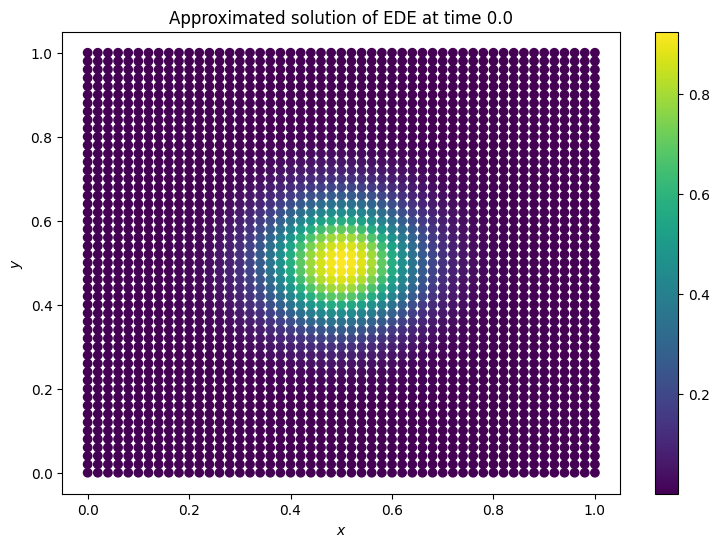

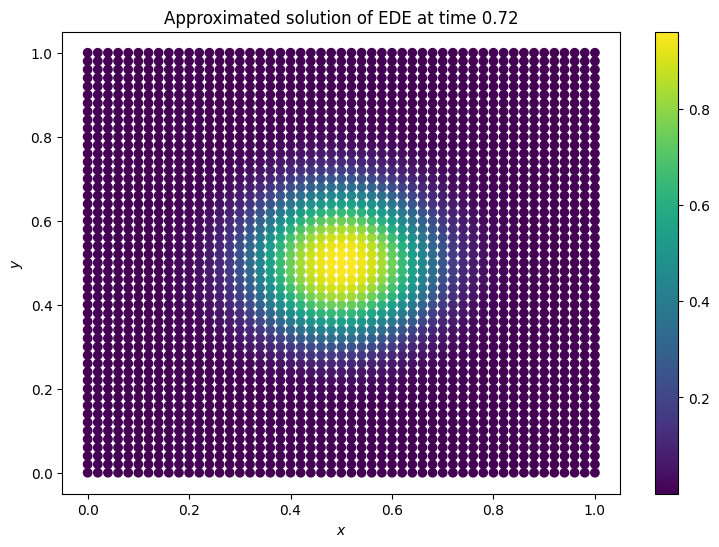

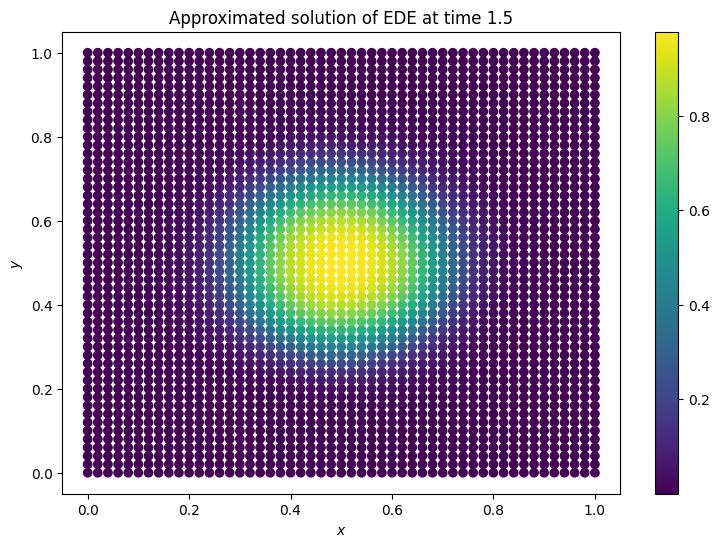

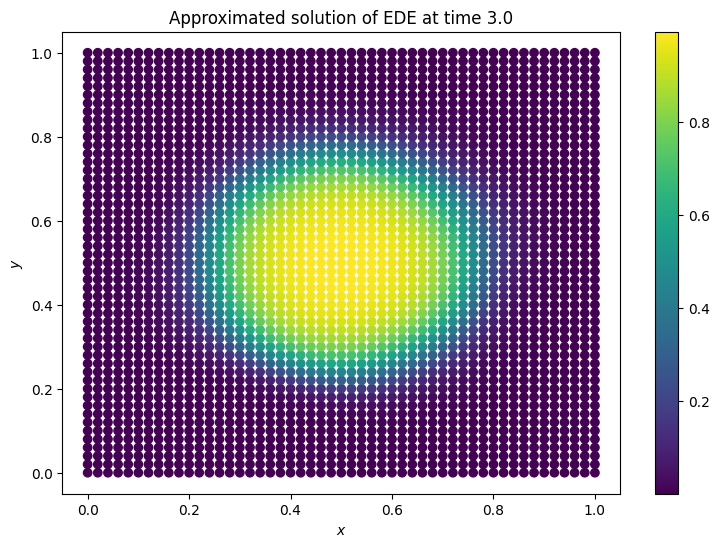

In [ ]:
X0 = [item[0] for item in X]
Y0 = [item[0] for item in Y]
U0 = [item[0] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(T[0][0][0]))
plt.show()


X0 = [item[12] for item in X]
Y0 = [item[12] for item in Y]
U0 = [item[12] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(T[0][12][0]))
plt.show()


X0 = [item[25] for item in X]
Y0 = [item[25] for item in Y]
U0 = [item[25] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(T[0][25][0]))
plt.show()


X0 = [item[50] for item in X]
Y0 = [item[50] for item in Y]
U0 = [item[50] for item in U]

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

img = ax.scatter(X0, Y0, c=U0)
fig.colorbar(img)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("Approximated solution of EDE at time " + str(T[0][50][0]))
plt.show()

Text(0, 0.5, 'Loss')

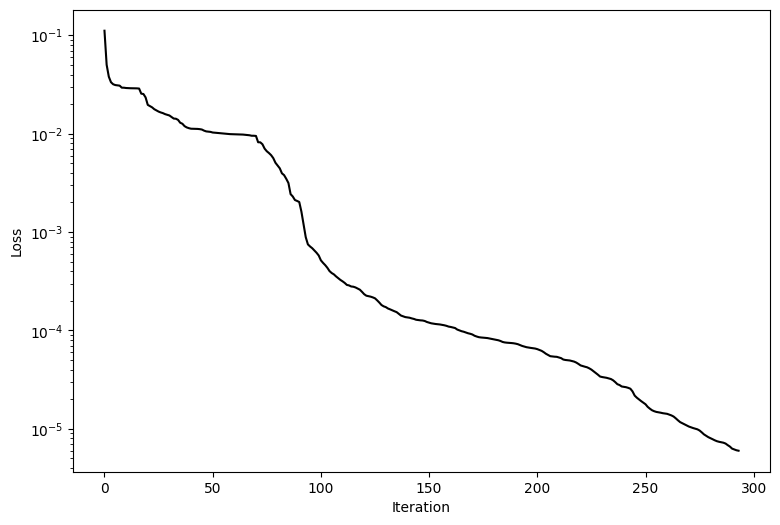

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist, "k-")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")

## Sample data from approximated solution

In [ ]:
times_for_data = np.linspace(lb[0], ub[0], 50 + 1)

dataset = []

# Sampling 1000 observations per timepoint
for i in [0, 10, 20, 30, 40, 50]:
    for j in range(1000):
        tt = i

        one = tf.random.uniform(shape=(), minval=0, maxval=50, dtype=tf.int32).numpy()
        two = tf.random.uniform(shape=(), minval=0, maxval=50, dtype=tf.int32).numpy()

        xx = [item[tt] for item in X]
        yy = [item[tt] for item in Y]
        uu = [item[tt] for item in U]

        dataset.append([times_for_data[tt], xx[one][two], yy[one][two], uu[one][two]])

In [ ]:
# Rename columns
simulated_data = pd.DataFrame(dataset, columns=["t", "x", "y", "u"])
simulated_data.head()

,t,x,y,u
0,0.0,0.44,0.10,0.000153
1,0.0,0.70,0.10,0.000650
2,0.0,0.28,0.46,0.076700
3,0.0,0.98,0.90,0.000004
4,0.0,0.76,0.44,0.026400


In [ ]:
# Save data as csv
simulated_data.to_csv("simulated_data_1.csv", index=False)